In [1]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline
rng_seed = 45510

# Download MNIST
# torchvision.datasets.MNIST('.', download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

Adversarial Images
In this part you will see how you can use the gradients of the network to generate adversarial
images. Using these images that look almost identical the original you will be able to fool
different neural networks. You will also see that these images also affect different neural
networks and expose a security issue of CNNs that malicious users can take advantage of.
An example is shown in Figure 4. You are encouraged to read the relevant papers [1, 2]
before solving this part.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW1/images/fig4.png"/></div>

<center>Figure 4: An adversarial example demonstrated in [1].</center>

Use the trained network from question 3 to generate adversarial images with
constraints. The constraints that you have are:

  1. You are not allowed to erase parts of the image, i.e. $I_\text{pert} \ge I$ at each pixel location.
  2. The perturbed image has to take valid values, i.e. $-1 \le I_\text{pert} \le 1$.

  The algorithm works as follows:
  
  1. Let $I$ be a test image of your dataset that you want to perturb that is classified correctly by the network. Let $I_\epsilon$ be the perturbation that you should initialize
with zeros.
  2. Feed $I_\text{pert} = I + I_\epsilon$ in the network.
  3. Calculate the loss given the ground truth label ($y_\mathrm{gt}$). Let the loss be $L(x,y |\theta)$ where $\theta$ are the learned weights.
  4. Compute the gradients with respect to $I_\text{pert}$, i.e., $\nabla_{I_\text{pert}} L(I_\text{pert}, y_\mathrm{gt} | \theta)$. Using backpropagation, compute $\nabla_{I_\epsilon} L(I_\epsilon,y_\mathrm{gt} | \theta)$, i.e. the gradients with respect to the perturbation.
  5. Use the Fast Gradient Sign method to update the perturbation, i.e., $I_\epsilon = I_\epsilon + \epsilon\,\text{sign}(\nabla_{I_\epsilon} L(I_\epsilon, y_\mathrm{gt}))$, where $\epsilon$ is a small constant of your choice.
  6. Repeat A-D until the network classify the input image $I_\text{pert}$ as an arbitrary
wrong category with confidence (probability) at least $90\%$.

  Generate 2 examples of adversarial images. Describe the difference between the adversarial images and the original images.

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Create your network here (do not change this name)
class DigitClassification(torch.nn.Module):
    def __init__(self):
        super(DigitClassification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 32, 5, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, 5, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 3 * 3, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor before fully connected layers
        x = self.relu4(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x

model_path = 'model.pth'
model = DigitClassification()
# Check if CUDA (GPU) is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model.to(device)  # Move the model to the appropriate device
print(model)
model.eval().load_state_dict(torch.load(model_path, map_location='cpu'))

DigitClassification(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


<All keys matched successfully>

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2, shuffle=False)

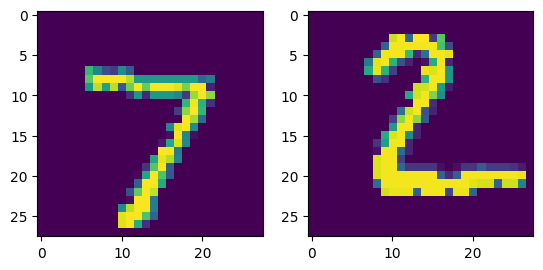

In [4]:
# Display the two images from test dataset
from PIL import Image
img = torchvision.transforms.ToPILImage()
images, labels = next(iter(testloader))

plt.subplot(121)
img_1 = img(images[0])
plt.imshow(img_1)

plt.subplot(122)
img_2 = img(images[1])
plt.imshow(img_2

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(0.9999, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(0.9990, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(0.9922, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(0.9418, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(0.8052, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(0.6404, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 1], device='cuda:0')
tensor(0.7918, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([5, 1], device='cuda:0')
tensor

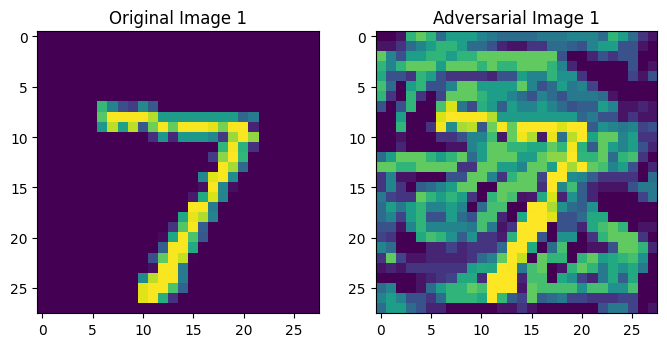

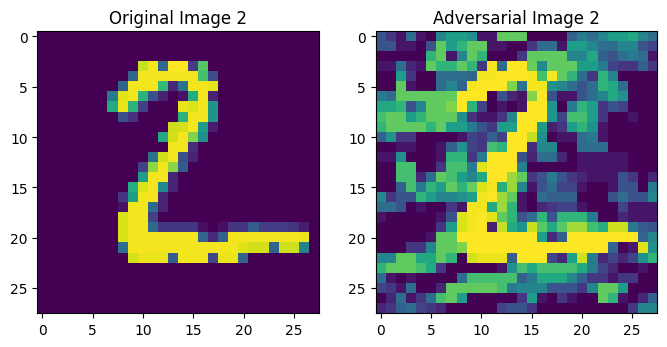

In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define a function to generate adversarial images
def arbitrary_adversary(model, image, original_label):
    loss_fn = nn.CrossEntropyLoss()  # Define the loss function
    epsilon = 0.05  # Small constant for perturbation
    confidence = 0
    predicted_label = original_label

    original_label_one_hot_encoded = torch.zeros(image.shape[0], 10)  # Convert label to one-hot format
    original_label_one_hot_encoded[torch.arange(image.shape[0]), original_label] = 1
    original_label_one_hot_encoded = original_label_one_hot_encoded.to(device)
    print(original_label_one_hot_encoded) # prints 7 & 2 (here) in one-hot encoded format

    image_eps = torch.zeros_like(image, requires_grad=True)  # Initialize perturbation
    image_pert = torch.empty_like(image, requires_grad=True)  # Perturbed image

    # Continue until confidence is above 90% and the predicted label is incorrect
    while not (confidence > 0.9 and (predicted_label != original_label).all()):
        # Apply the perturbation and clamp values to satisfy constraint 2
        image_pert = torch.clamp(image + image_eps, -1, 1)

        # Get the network's output
        output = model(image_pert)

        # Apply softmax to convert to probabilities
        output_prob = torch.nn.functional.softmax(output, dim=1)

        # Get the predicted label
        predicted_label = output_prob.argmax(dim=1)
        confidence = output_prob.max()
        print(confidence)
        print(predicted_label)

        model.zero_grad()  # Zero out gradients

        # Compute gradients with respect to perturbed image
        loss = loss_fn(output, original_label_one_hot_encoded)

        # Compute gradients with respect to the perturbation
        loss_grad_e = torch.autograd.grad(loss, image_eps, retain_graph=True, grad_outputs=torch.ones_like(loss))[0]

        # Update the perturbation with FGSM while satisfying constraint 1
        image_eps = torch.clamp(image_eps + epsilon * torch.sign(loss_grad_e), 0, None)

    return image_pert

images, labels = images.to(device, dtype=torch.float), labels.to(device)
image_perturbed = arbitrary_adversary(model, images, labels)

# Display original and adversarial images
for i in range(2):
    plt.figure(figsize=(8, 4))

    plt.subplot(121)
    plt.title(f"Original Image {i + 1}")
    plt.imshow(img(images[i]))

    plt.subplot(122)
    plt.title(f"Adversarial Image {i + 1}")
    plt.imshow(img(image_perturbed[i]))

    plt.show()

* Visible Perturbations:

In adversarial images, I can observe the presence of perturbations or subtle alterations in the pixel values when compared to the original images.
These perturbations are crafted in such a way that they are often imperceptible to the human eye but are strategically designed to manipulate the neural network's classification.


* Recognition of Digits:

Both original and adversarial images retain the recognizability of the digits 7 and 2. This indicates that despite the presence of perturbations, the core features of the digits are still preserved, allowing humans to identify them. The key difference lies in the presence of perturbations in adversarial images while maintaining the recognition of the underlying content. These perturbations are designed to exploit vulnerabilities in the neural network's classification process, causing it to make incorrect predictions while appearing visually similar to the original data to a human observer.

* Juxtaposing my observations to the reference papers [1]:

I can understand that these small perturbations come together to 


For a test image from the dataset, choose a target label yt that you want the network to classify your image as and compute a perturbed image. Note that this is different from what you are asked in part 1, because you want your network to believe that the image has a particular label, not just misclassify the image. You need to modify appropriately the loss function and then perform gradient descent as before. You should still use the constraints from part 1.

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(0.9999, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(0.9989, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(0.9850, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(0.8155, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([7, 2], device='cuda:0')
tensor(0.8051, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([8, 1], device='cuda:0')
tensor(0.9790, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([8, 1], device='cuda:0')
tensor(0.9974, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([8, 5], device='cuda:0')


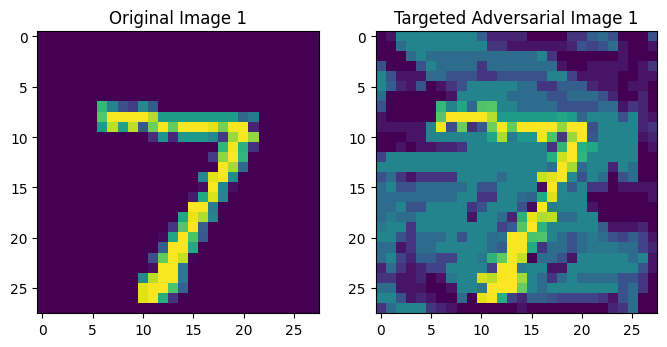

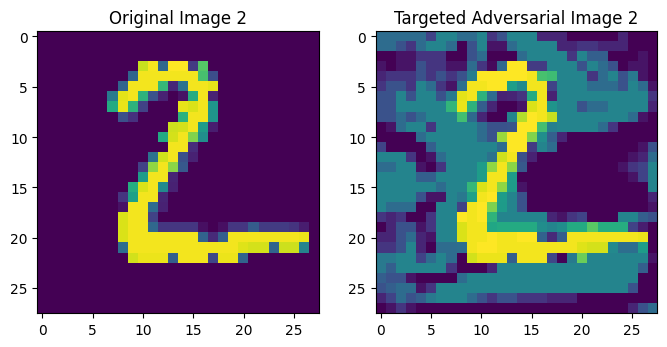

In [8]:
# don't change the signature of this function (image, image_pert -> [N, 1, H, W])
def targeted_adversary(model, image, target_label):
    loss_fn = nn.CrossEntropyLoss()  # Define the loss function
    epsilon = 0.05  # Small constant for perturbation
    confidence = 0
    predicted_label = target_label

    # Convert the target label to one-hot format
    target_label_one_hot_encoded = torch.zeros(image.shape[0], 10)
    target_label_one_hot_encoded[torch.arange(image.shape[0]), target_label] = 1
    target_label_one_hot_encoded = target_label_one_hot_encoded.to(device)
    print(target_label_one_hot_encoded)

    image_eps = torch.zeros_like(image, requires_grad=True)  # Initialize perturbation
    image_pert = torch.empty_like(image, requires_grad=True)  # Perturbed image

    # Continue until confidence is above 90% and the predicted label matches the target
    while not (confidence > 0.9 and (predicted_label == target_label).all()):
        # Apply the perturbation and clamp values to satisfy constraint 2
        image_pert = torch.clamp(image + image_eps, -1, 1)

        # Get the network's output
        output = model(image_pert)

        # Apply softmax to convert to probabilities
        output_prob = torch.nn.functional.softmax(output, dim=1)

        # Get the predicted label
        predicted_label = output_prob.argmax(dim=1)
        confidence = output_prob.max()
        print(confidence)
        print(predicted_label)

        model.zero_grad()  # Zero out gradients

        # Compute the loss with a negative sign to minimize it
        loss = -loss_fn(output, target_label_one_hot_encoded)

        # Compute gradients with respect to the perturbation
        loss_grad_e = torch.autograd.grad(loss, image_eps, retain_graph=True, grad_outputs=torch.ones_like(loss))[0]

        # Update the perturbation with FGSM while satisfying constraint 1
        image_eps = torch.clamp(image_eps + epsilon * torch.sign(loss_grad_e), 0, None)

    return image_pert

target_labels = torch.tensor([8, 5])  # Specify the target label(s)
images, target_labels = images.to(device, dtype=torch.float), target_labels.to(device)
image_target_pert = targeted_adversary(model, images, target_labels)

# Display original and targeted adversarial images
for i in range(2):
    plt.figure(figsize=(8, 4))

    plt.subplot(121)
    plt.title(f"Original Image {i + 1}")
    plt.imshow(img(images[i]))

    plt.subplot(122)
    plt.title(f"Targeted Adversarial Image {i + 1}")
    plt.imshow(img(image_target_pert[i]))

    plt.show()

Retrain the network from the previous problem. Use some of the adversarial images you generated in parts (1) and (2) and feed them in the retrained network. What do you observe?

In [9]:
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

# Define the transformation for the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create training dataset
main_training_set = torchvision.datasets.MNIST(root='.', train=True, download=False, transform=transform)
main_train_loader = torch.utils.data.DataLoader(main_training_set, batch_size = len(main_training_set), shuffle = False)
main_train_images, main_train_labels = next(iter(main_train_loader))
pert_train_loader = torch.utils.data.DataLoader(main_training_set, batch_size = int(0.25*len(main_training_set)), shuffle = False)
pert_train_images, pert_train_labels = next(iter(pert_train_loader))

pert_train_images, pert_train_labels = pert_train_images.to(device, dtype=torch.float), pert_train_labels.to(device)
pert_train_images = arbitrary_adversary(model, pert_train_images, pert_train_labels)

X_train = Variable(torch.cat((main_train_images.to(device, dtype=torch.float), pert_train_images)))
y_train = Variable(torch.cat((main_train_labels.to(device, dtype=torch.float), pert_train_labels)))
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Create testing dataset
main_testing_set = torchvision.datasets.MNIST(root='.', train=False, download=False, transform=transform)
main_test_loader = torch.utils.data.DataLoader(main_testing_set, batch_size = len(main_testing_set), shuffle = False)
main_test_images, main_test_labels = next(iter(main_test_loader))
pert_test_loader = torch.utils.data.DataLoader(main_testing_set, batch_size = int(0.25*len(main_testing_set)), shuffle = False)
pert_test_images, pert_test_labels = next(iter(pert_test_loader))

pert_test_images, pert_test_labels = pert_test_images.to(device, dtype=torch.float), pert_test_labels.to(device)
pert_test_images = arbitrary_adversary(model, pert_test_images, pert_test_labels)

X_test = Variable(torch.cat((main_test_images.to(device, dtype=torch.float), pert_test_images)))
y_test = Variable(torch.cat((main_test_labels.to(device, dtype=torch.float), pert_test_labels)))
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor([5, 0, 4,  ..., 7, 1, 7], device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor([3, 0, 4,  ..., 7, 1, 7], device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor([3, 0, 4,  ..., 7, 1, 7], device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor([3, 0, 4,  ..., 7, 1, 7], device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor([3, 0, 4,  ..., 7, 1, 7], device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor([3, 0, 4,  ..., 7, 4, 4], device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor([3, 0, 1,  ..., 4, 4, 4], device='cuda:0')
tensor(1., devi

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and testing statistics
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

# Training loop
for epoch in range(10):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.type(torch.LongTensor)   # casting to long
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy.append(100 * correct_train / total_train)
    train_losses.append(train_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy[-1]:.2f}%")

    # Testing loop
    correct_test = 0
    total_test = 0
    test_running_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            labels = labels.type(torch.LongTensor)   # casting to long
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_loss = test_running_loss / len(test_loader)
        test_losses.append(test_loss)
        test_accuracy.append(100 * correct_test / total_test)

    print(f"Epoch {epoch + 1}, Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy[-1]:.2f}%")

Epoch 1, Training Loss: 0.2787, Training Accuracy: 93.24%
Epoch 1, Testing Loss: 0.0919, Testing Accuracy: 97.33%
Epoch 2, Training Loss: 0.0451, Training Accuracy: 98.53%
Epoch 2, Testing Loss: 0.0623, Testing Accuracy: 98.37%
Epoch 3, Training Loss: 0.0262, Training Accuracy: 99.14%
Epoch 3, Testing Loss: 0.0499, Testing Accuracy: 98.66%
Epoch 4, Training Loss: 0.0181, Training Accuracy: 99.41%
Epoch 4, Testing Loss: 0.0407, Testing Accuracy: 98.87%
Epoch 5, Training Loss: 0.0131, Training Accuracy: 99.59%
Epoch 5, Testing Loss: 0.0403, Testing Accuracy: 98.96%
Epoch 6, Training Loss: 0.0097, Training Accuracy: 99.70%
Epoch 6, Testing Loss: 0.0417, Testing Accuracy: 98.93%
Epoch 7, Training Loss: 0.0074, Training Accuracy: 99.79%
Epoch 7, Testing Loss: 0.0378, Testing Accuracy: 99.01%
Epoch 8, Training Loss: 0.0061, Training Accuracy: 99.81%
Epoch 8, Testing Loss: 0.0363, Testing Accuracy: 99.10%
Epoch 9, Training Loss: 0.0043, Training Accuracy: 99.88%
Epoch 9, Testing Loss: 0.0437,

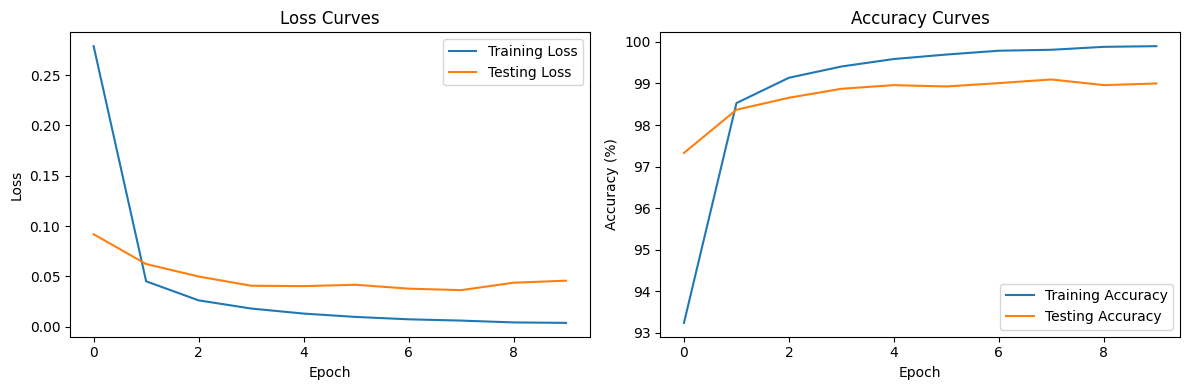

In [11]:
# Plot training and testing curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
torch.save(model.state_dict(), 'model_2.pth')

* After adding 25% of the data as perturbed images, it can be noticed that the model trained without perturbed images has slightly higher accuracy.
* However, the model trained with perturbed images has become more robust to adversarial attacks.
* One notable difference I pointed at the first glance what that the above curves aren't spiky as compared to the training w/o adversarial images.

<!-- END QUESTION -->

## References
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW1/images/refs.png"/, width=600
         ></div>